In [ ]:
import os
import numpy as np

from astropy.io import fits

from scipy.stats import chi2
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

import json

from tqdm import tqdm

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl

# Define matplotlib style
mpl.style.use('classic')
mpl.rc('xtick', labelsize=23); mpl.rc('ytick', labelsize=23)
mpl.rc('xtick.major', size=15 , width=2)
mpl.rc('xtick.minor', size=8, width=2, visible=True)
mpl.rc('ytick.major', size=15 , width=2)
mpl.rc('ytick.minor', size=8, width=2, visible=True)
mpl.rc('lines',linewidth=3, markersize=20)
mpl.rc('axes', linewidth=2, labelsize=30, labelpad=2.5)
mpl.rc('legend', fontsize=25, loc='best', frameon=False, numpoints=1)

mpl.rc('font', family='STIXGeneral')
mpl.rc('mathtext', fontset='stix')

In [ ]:
def show_lightcurve(lightcurve):
    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_axes([0.12,0.12,0.83,0.83])

    if 'flux_err' in lightcurve.keys():
        ax.errorbar(lightcurve['time'],lightcurve['flux'],lightcurve['flux_err'],fmt=' ',marker='s',markersize=5,capsize=8,alpha=0.5)
    else:
        ax.scatter(lightcurve['time'],lightcurve['flux'],marker='s',s=5,alpha=0.5)

    ax.set_xlim(lightcurve['time'][0],lightcurve['time'][-1])
    ax.set_ylim(np.median(lightcurve['flux'])-10*np.std(lightcurve['flux']),np.median(lightcurve['flux'])+10*np.std(lightcurve['flux']))

    ax.set_xlabel(r'Time [BJD $-$ 2454833]')
    ax.set_ylabel(r'Flux [e$^-$/s]')

    plt.show()

In [ ]:
def read_single_lightcurve(filename,show_header=False):
    # Openning the FITS file
    with fits.open(filename) as hdul:
        # Printing the FITS file information
        hdul.info()

        # Reading the lightcurve data and header
        hdu = hdul[1]
        data = hdu.data
        header = hdu.header

    # Printing the header
    if show_header:
        print(repr(header))

    # Reformatting the data
    lightcurve = {
        'time' : np.array(data['TIME']),
        'flux' : np.array(data['PDCSAP_FLUX']),
        'flux_err' : np.array(data['PDCSAP_FLUX_ERR']),
    }

    nan_mask = np.logical_or(np.isnan(lightcurve['flux']),np.isnan(lightcurve['flux_err']))
    for key in lightcurve:
        lightcurve[key] = lightcurve[key][~nan_mask]

    return lightcurve

Filename: Kepler/0007/000757450/kplr000757450-2012032013838_slc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   38910R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (6, 5)   int32   
XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                38910 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields               

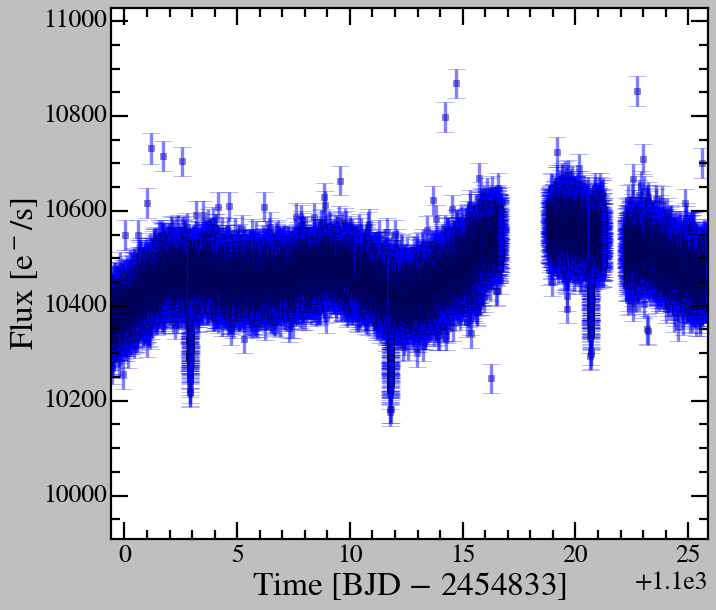

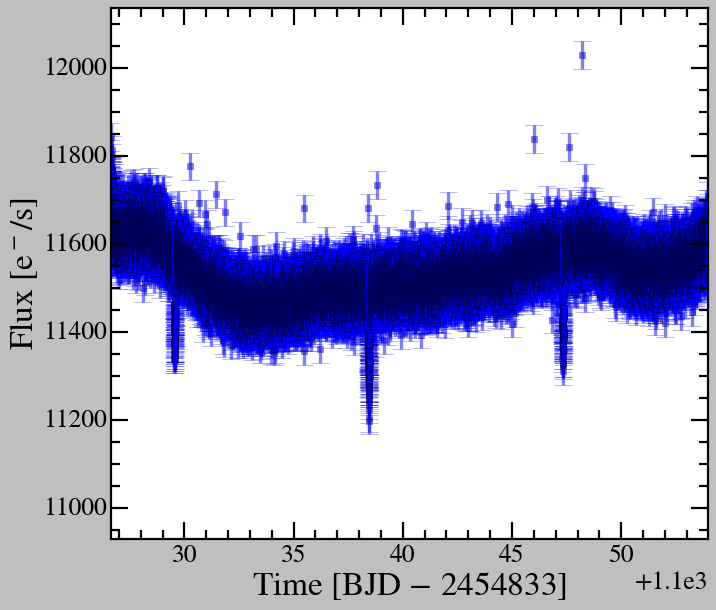

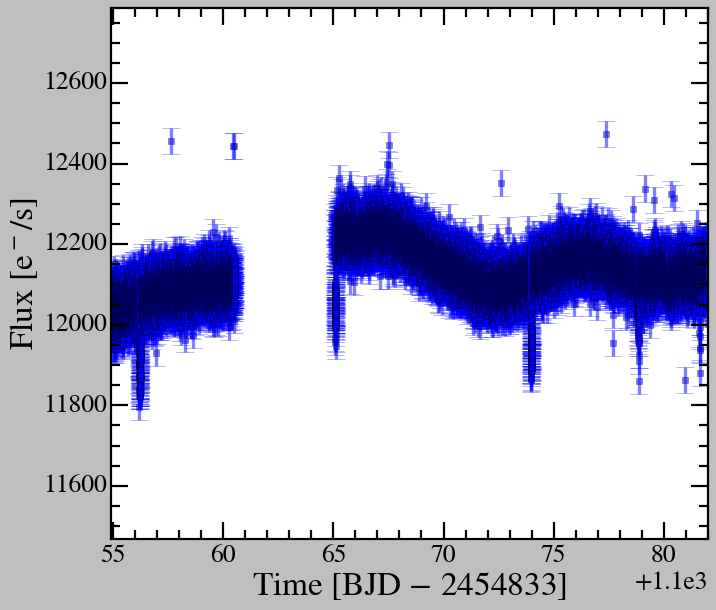

In [ ]:
lightcurve_1 = read_single_lightcurve('000757450/kplr000757450-2012032013838_slc.fits',True)
lightcurve_2 = read_single_lightcurve('000757450/kplr000757450-2012060035710_slc.fits')
lightcurve_3 = read_single_lightcurve('000757450/kplr000757450-2012088054726_slc.fits')

show_lightcurve(lightcurve_1)
show_lightcurve(lightcurve_2)
show_lightcurve(lightcurve_3)

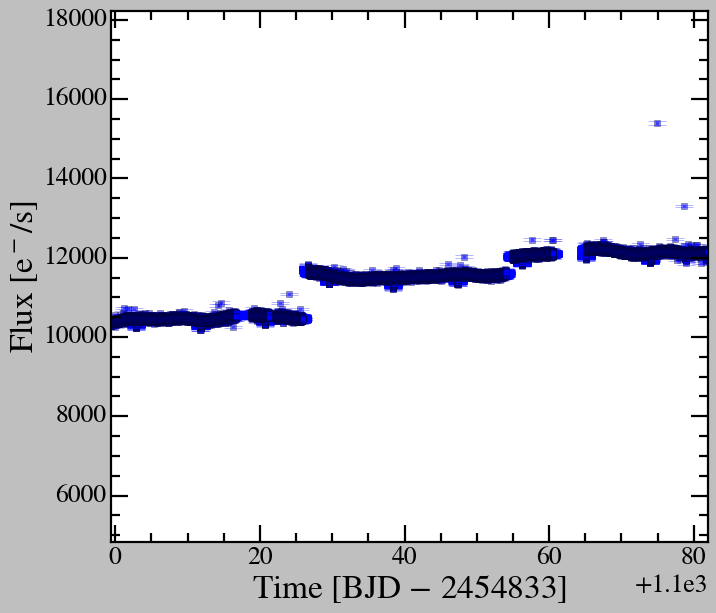

In [ ]:
all_lightcurves = {
    key : np.append(np.append(lightcurve_1[key],lightcurve_2[key]),lightcurve_3[key]) for key in ['time','flux','flux_err']
}

show_lightcurve(all_lightcurves)

In [ ]:
def read_object_lightcurve(object_dir,show_header=False):
    lightcurve = {
        'time' : np.array([]),
        'flux' : np.array([]),
        'flux_err' : np.array([]),
    }

    date = []
    all_lightcurves = []
    for file in os.scandir(object_dir):
        if file.name[-4:] == 'fits':
            ilightcurve = read_single_lightcurve(file.path,show_header=show_header)

            date.append(file.name)
            all_lightcurves.append(ilightcurve)

    all_lightcurves = np.array(all_lightcurves)[np.argsort(date)]
    for ilightcurve in all_lightcurves:
        if lightcurve['flux'].shape[0]:
            scaling = lightcurve['flux'][-1] / ilightcurve['flux'][0]

            ilightcurve['flux'] *= scaling
            ilightcurve['flux_err'] *= scaling

        for key in lightcurve:
            lightcurve[key] = np.append(lightcurve[key],ilightcurve[key])

    return lightcurve

Filename: Kepler/0007/000757450/kplr000757450-2012088054726_slc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   39840R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (6, 5)   int32   
Filename: Kepler/0007/000757450/kplr000757450-2012032013838_slc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   38910R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (6, 5)   int32   
Filename: Kepler/0007/000757450/kplr000757450-2012060035710_slc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   40200R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E

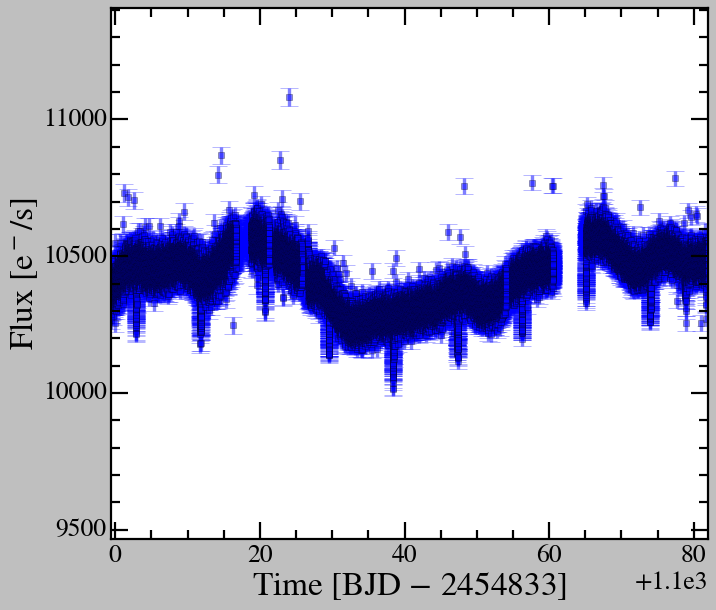

In [ ]:
lightcurve = read_object_lightcurve('000757450')
show_lightcurve(lightcurve)

In [ ]:
def normalize_lightcurve(lightcurve,nbin=100):
    bins = np.linspace(lightcurve['time'][0],lightcurve['time'][-1],nbin+1)
    bin_indices = np.digitize(lightcurve['time'],bins)
    bin_mask = [
        np.where(bin_indices == i) for i in range(1,nbin+1)
    ]

    background = {
        'time' : (bins[1:] + bins[:-1]) / 2,
        'flux' : np.array([
            np.median(lightcurve['flux'][mask]) for mask in bin_mask
        ]),
    }

    nan_mask = np.isnan(background['flux'])
    background_flux = CubicSpline(background['time'][~nan_mask],background['flux'][~nan_mask])(lightcurve['time'])

    edge_mask = np.logical_and(lightcurve['time'] > background['time'][0], lightcurve['time'] < background['time'][-1])
    norm_lightcurve = {
        'time' : lightcurve['time'][edge_mask],
        'flux' : (lightcurve['flux'] / background_flux)[edge_mask],
        'flux_err' : (lightcurve['flux_err'] / background_flux)[edge_mask],
    }

    return norm_lightcurve, {'time':lightcurve['time'],'flux':background_flux}

def drop_outlier(lightcurve,drop_rate=np.array([1e-4,1e-3])):
    sorted_flux_indices = np.argsort(lightcurve['flux'])
    drop_num = (drop_rate*sorted_flux_indices.shape[0]).astype(int)

    drop_indices = np.append(sorted_flux_indices[:drop_num[0]],sorted_flux_indices[-drop_num[1]:])

    return {
        key : np.delete(lightcurve[key],drop_indices) for key in lightcurve
    }

/Users/vinhtran/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vinhtran/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


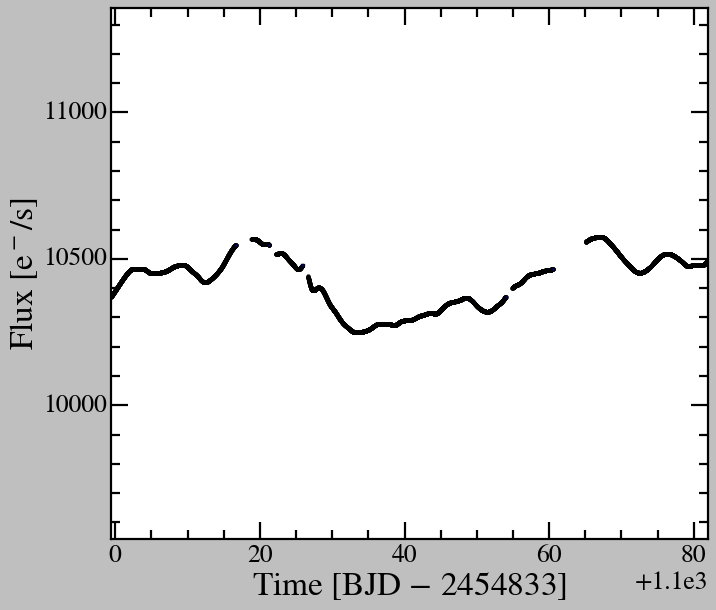

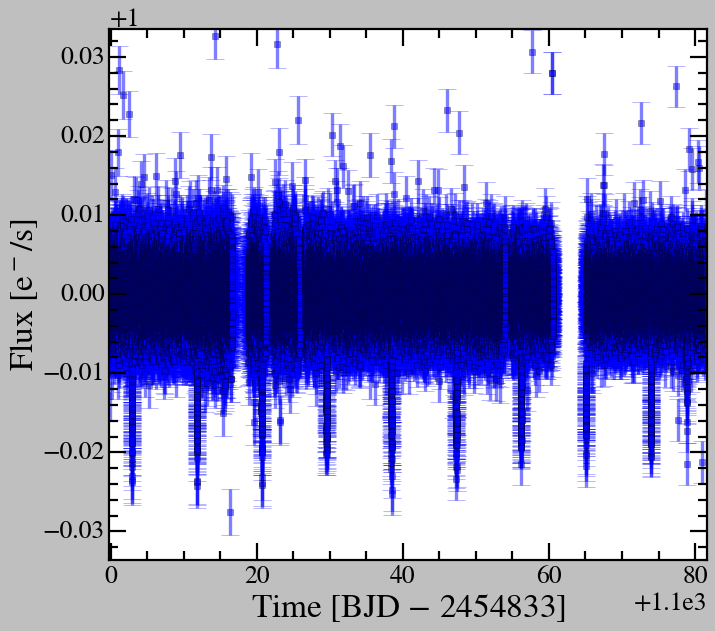

In [ ]:
norm_lightcurve, background_lightcurve = normalize_lightcurve(lightcurve)

show_lightcurve(background_lightcurve)
show_lightcurve(norm_lightcurve)

In [ ]:
class BoxLeastSquares:
    def __init__(self,time,flux,flux_err,transit_phase_proposal=np.linspace(0,0.99,100),transit_frac_proposal=np.linspace(0.05,0.20,31),period_proposal=None):
        self.time = time
        self.flux = flux
        self.flux_err = flux_err

        self.transit_phase_proposal = transit_phase_proposal
        self.transit_frac_proposal = transit_frac_proposal

        self.period_proposal = period_proposal if period_proposal else np.linspace(1e-3,1,2000) * (self.time[-1]-self.time[0])/4

        if os.path.exists('transit_periodogram.json'):
            with open('transit_periodogram.json','r') as f:
                self.periodogram = json.load(f)
        else:
            self.periodogram = {
                'period' : [],
                'chisqr' : [],
                'transit_phase' : [],
                'transit_frac' : [],
                'transit_depth' : [],
            }

        self.detrend_lightcurve()

    def detrend_lightcurve(self):
        self.trend = np.mean(self.flux/self.flux_err**2) / np.mean(1/self.flux_err**2)
        self.flux_dtr = self.flux - self.trend

        self.H0_chisqr = np.sum(self.flux_dtr**2 / self.flux_err**2)

    def perturb_lightcurve(self,period,transit_phase):
        time_bins = np.arange(transit_phase*period,self.time[-1],period)
        num_period = np.digitize(self.time,time_bins) - 1

        perturb_time = self.time - num_period*period
        return perturb_time

    def transit_depth_fit(self,perturb_time,period,transit_frac):
        in_transit_mask = perturb_time < period*transit_frac
        out_transit_mask = np.logical_not(in_transit_mask)

        def transit_loss(depth):
            baseline = - depth * np.sum(1/self.flux_err[in_transit_mask]**2) / np.sum(1/self.flux_err[out_transit_mask]**2)

            return np.sum( (depth - self.flux_dtr[in_transit_mask])**2 / self.flux_err[in_transit_mask]**2) + np.sum( (baseline - self.flux_dtr[out_transit_mask])**2 / self.flux_err[out_transit_mask]**2)

        regression_result = minimize(transit_loss,[-0.01])

        depth = regression_result.x[0]
        loss = regression_result.fun

        return depth, loss

    def likelihood_fitting_per_period(self,period):
        best_transit_phase = None
        best_transit_frac = None

        best_depth = None

        best_loss = np.inf

        for transit_phase in self.transit_phase_proposal:
            perturb_time = self.perturb_lightcurve(period,transit_phase)

            for transit_frac in self.transit_frac_proposal:
                depth, loss = self.transit_depth_fit(perturb_time,period,transit_frac)

                if loss < best_loss:
                    best_loss = loss

                    best_transit_phase = transit_phase
                    best_transit_frac = transit_frac

                    best_depth = depth

        return best_loss, best_transit_phase, best_transit_frac, best_depth

    def calculate_periodogram(self):
        for period in tqdm(self.period_proposal):
            if period in self.periodogram['period']:
                continue

            chisqr, transit_phase, transit_frac, transit_depth = self.likelihood_fitting_per_period(period)

            self.periodogram['period'].append(period)
            self.periodogram['chisqr'].append(chisqr)
            self.periodogram['transit_phase'].append(transit_phase)
            self.periodogram['transit_frac'].append(transit_frac)
            self.periodogram['transit_depth'].append(transit_depth)

            with open('transit_periodogram.json','w') as f:
                json.dump(self.periodogram,f)

    def show_periodogram(self):
        delta_chisqr = self.H0_chisqr - np.array(self.periodogram['chisqr'])

        best_index = np.argmax(delta_chisqr)

        fig = plt.figure(figsize=(9, 8))
        ax = fig.add_axes([0.12,0.12,0.83,0.83])

        ax.plot(np.array(self.periodogram['period']),delta_chisqr)

        ax.axvspan(self.periodogram['period'][best_index-20],self.periodogram['period'][best_index+20],color='orangered',alpha=0.25)
        secondary_peaks = self.periodogram['period'][best_index] * np.array([1/8,1/7,1/6,1/5,1/4,1/3,1/2,1,2,3,4,5,6,7,8])
        for peak in secondary_peaks:
            ax.axvline(peak,color='orangered',ls='--',alpha=0.5)

        ax.set_xlabel('Period [day]')
        ax.set_ylabel(r'$\Delta \chi^2$')

        ax.set_xlim(self.periodogram['period'][0],self.periodogram['period'][-1])
        ax.set_ylim(0)

        plt.show()

    def show_fit(self):
        delta_chisqr = self.H0_chisqr - np.array(self.periodogram['chisqr'])

        best_index = np.argmax(delta_chisqr)
        best_period = self.periodogram['period'][best_index]
        best_transit_phase = self.periodogram['transit_phase'][best_index]
        best_transit_frac = self.periodogram['transit_frac'][best_index]
        best_transit_depth = self.periodogram['transit_depth'][best_index]

        fig = plt.figure(figsize=(9, 8))
        ax = fig.add_axes([0.12,0.12,0.83,0.83])

        ax.errorbar(self.time,self.flux,self.flux_err,fmt=' ',marker='s',markersize=5,capsize=8,alpha=0.5)
        for i in range(int((self.time[-1]-self.time[0])/best_period+2)):
            ax.axvspan(best_period*(int(self.time[0]/best_period)+i)+(best_transit_phase-best_transit_frac/2)*best_period,best_period*(int(self.time[0]/best_period)+i)+(best_transit_phase+best_transit_frac/2)*best_period,ls='--',color='orangered',alpha=0.25)

        ax.set_xlim(self.time[0],self.time[-1])
        ax.set_ylim(np.median(self.flux)-10*np.std(self.flux),np.median(self.flux)+10*np.std(self.flux))

        ax.set_xlabel(r'Time [BJD $-$ 2454833]')
        ax.set_ylabel(r'Flux')


In [ ]:
test_bls = BoxLeastSquares(norm_lightcurve['time'],norm_lightcurve['flux'],norm_lightcurve['flux_err'])
#test_bls.calculate_periodogram()

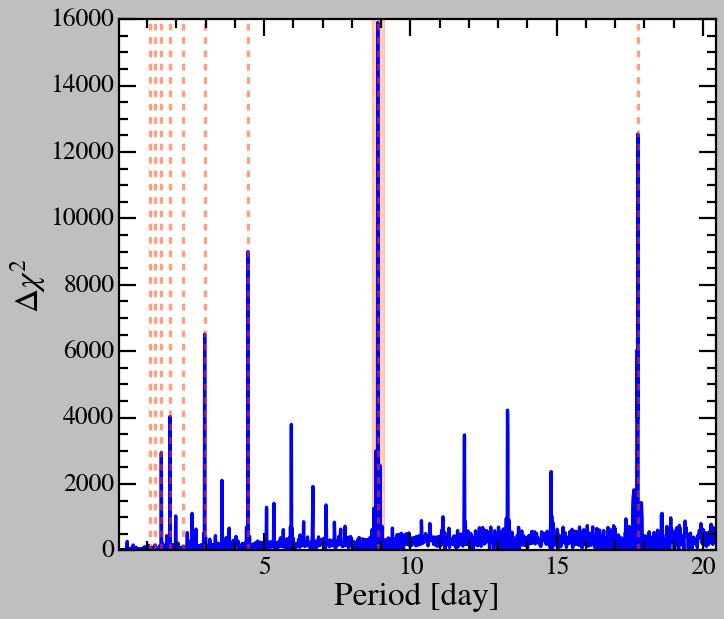

In [ ]:
test_bls.show_periodogram()

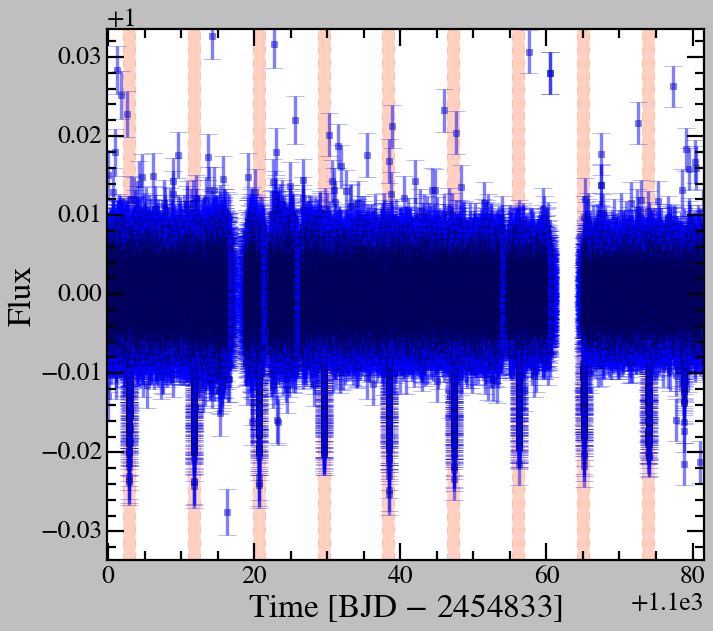

In [ ]:
test_bls.show_fit()

In [ ]:
test_bls.likelihood_fitting_per_period(8.885634705456848)

(135892.38520776702, 0.12, 0.125, -0.01537403171696888)

In [ ]:
from astropy.timeseries import BoxLeastSquares

durations = np.linspace(0.05, 0.2, 10)
model = BoxLeastSquares(norm_lightcurve['time'], norm_lightcurve['flux'])
results = model.autopower(durations, frequency_factor=5.0)

Text(0, 0.5, 'log likelihood')

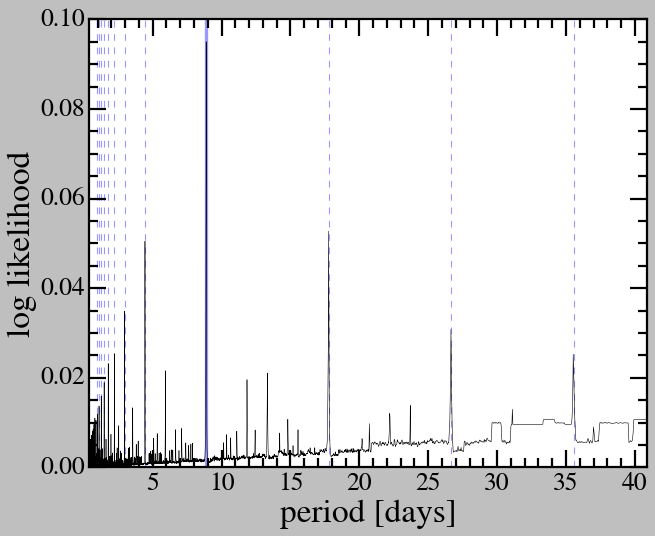

In [ ]:
# Find the period of the peak
period = results.period[np.argmax(results.power)]

fig, ax = plt.subplots(1, 1, figsize=(9, 7))

# Highlight the harmonics of the peak period
ax.axvline(period, alpha=0.4, lw=3)
for n in range(2, 10):
    ax.axvline(n*period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period / n, alpha=0.4, lw=1, linestyle="dashed")

# Plot the periodogram
ax.plot(results.period, results.power, "k", lw=0.5)

ax.set_xlim(results.period.min(), results.period.max())
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood")

In [ ]:
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

model.compute_stats(period, duration, t0)

{'transit_times': array([1102.90468114, 1111.79031585, 1120.67595056, 1129.56158526,
        1138.44721997, 1147.33285467, 1156.21848938, 1165.10412408,
        1173.98975879]),
 'per_transit_count': array([96, 96, 95, 95, 96, 95, 96, 95, 95]),
 'per_transit_log_likelihood': array([0.01082742, 0.01069442, 0.01084688, 0.00956965, 0.01099288,
        0.0115102 , 0.01007682, 0.00977257, 0.01070932]),
 'depth': (0.01487238382131928, 0.03425898112396299),
 'depth_phased': (-0.00014589349237503768, 0.03686636576884694),
 'depth_half': (0.007916490820039424, 0.025191293330936202),
 'depth_odd': (0.014768360819650161, 0.05132451022428434),
 'depth_even': (0.014955297552775249, 0.0458430326544524),
 'harmonic_amplitude': 0.00018048453516395624,
 'harmonic_delta_log_likelihood': -0.09336321846731155}

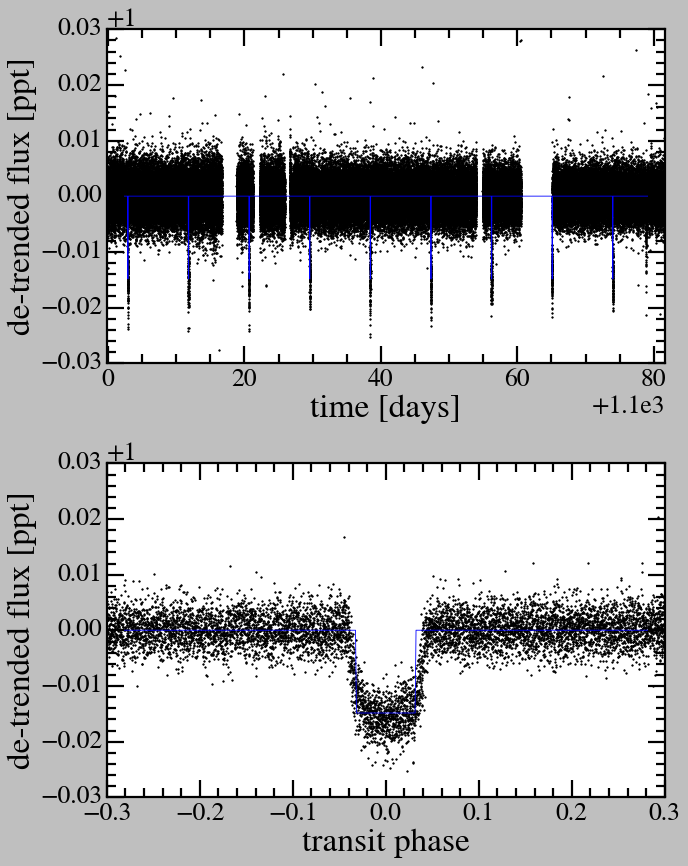

In [ ]:
# Extract the parameters of the best-fit model
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

fig, axes = plt.subplots(2, 1, figsize=(9, 12))
fig.subplots_adjust(hspace=0.3)

# Plot the light curve and best-fit model
ax = axes[0]
ax.plot(norm_lightcurve['time'], norm_lightcurve['flux'], ".k", ms=3)
x = np.linspace(norm_lightcurve['time'].min(), norm_lightcurve['time'].max(), 3*norm_lightcurve['time'].shape[0])
f = model.model(x, period, duration, t0)
ax.plot(x, f, lw=0.75)
ax.set_xlim(norm_lightcurve['time'].min(), norm_lightcurve['time'].max())
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]")
ax.set_ylim(0.97,1.03)

# Plot the folded data points within 0.5 days of the transit time
ax = axes[1]
x = (norm_lightcurve['time'] - t0 + 0.5*period) % period - 0.5*period
m = np.abs(x) < 0.5
ax.plot(x[m], norm_lightcurve['flux'][m], ".k", ms=3)

# Over-plot the best fit model
x = np.linspace(-0.5, 0.5, 1000)
f = model.model(x + t0, period, duration, t0)
ax.plot(x, f, lw=0.75)
ax.set_xlim(-0.3, 0.3)
ax.set_xlabel("transit phase")
ax.set_ylabel("de-trended flux [ppt]")

plt.show()